# Graph Convolutional Networks

In [1]:
import os
import math
import time
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

## Set Configs

In [3]:
torch.manual_seed(10)
np.random.seed(9)

In [4]:
N_EPOCHS = 250
LR = 0.01
WEIGHT_DECAY = 5e-4
N_HIDDEN = 16
DROPOUT = 0.5

In [5]:
# decide which device we want to run on
device = torch.device('cuda:0' if (torch.cuda.is_available() and n_gpu > 0) else 'cpu')

## Set Helpers

In [6]:
def one_hot_encode(labels):
    
    classes = set(labels)
    classes_dict = { c: np.identity(len(classes))[i, :] for i, c in enumerate(classes) }
    labels_one_hot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    
    return labels_one_hot

In [7]:
def normalize(matrix):
    
    row_sum = np.array(matrix.sum(1))
    r_inv = np.power(row_sum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    matrix = r_mat_inv.dot(matrix)
    
    return matrix

In [8]:
def calculate_accuracy(output, labels):
    
    predictions = output.max(1)[1].type_as(labels)
    corrects = predictions.eq(labels).double()
    corrects = corrects.sum()
    
    return corrects / len(labels)

In [9]:
def sparse_matrix_to_sparse_tensor(sparse_matrix):
    
    sparse_matrix = sparse_matrix.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_matrix.row, sparse_matrix.col)).astype(np.int64))
    values = torch.from_numpy(sparse_matrix.data)
    shape = torch.Size(sparse_matrix.shape)
    
    return torch.sparse.FloatTensor(indices, values, shape)

In [10]:
def load_data(path="./datasets/cora/", dataset="cora"):
    
    print('Loading {} datasets...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset), dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = one_hot_encode(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = { j: i for i, j in enumerate(idx) }
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),dtype=np.int32)
    
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adjacency = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                         shape=(labels.shape[0], labels.shape[0]),
                         dtype=np.float32)

    # build symmetric adjacency matrix
    adjacency = adjacency + adjacency.T.multiply(adjacency.T > adjacency) - adjacency.multiply(adjacency.T > adjacency)

    features = normalize(features)
    adjacency = normalize(adjacency + sp.eye(adjacency.shape[0]))

    idx_train = range(140)
    idx_valid = range(200, 500)
    idx_test = range(500, 1500)
    
    idx_train = torch.LongTensor(idx_train)
    idx_valid = torch.LongTensor(idx_valid)
    idx_test = torch.LongTensor(idx_test)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adjacency = sparse_matrix_to_sparse_tensor(adjacency)

    return adjacency, features, labels, idx_train, idx_valid, idx_test

## Load Data

In [11]:
adjacency, features, labels, idx_train, idx_valid, idx_test = load_data()

Loading cora datasets...


## Build [Graph](https://arxiv.org/pdf/1609.02907.pdf) Convolution Networks Architecture

In [12]:
class GraphConvolution(Module):

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adjacency):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adjacency, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

In [13]:
class GCN(nn.Module):
    
    def __init__(self, n_features, n_hidden, n_class, dropout):
        super(GCN, self).__init__()

        self.gc1_layer = GraphConvolution(n_features, n_hidden)
        self.gc2_layer = GraphConvolution(n_hidden, n_class)
        self.dropout = dropout

    def forward(self, x, adjacency):
        x = F.relu(self.gc1_layer(x, adjacency))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.log_softmax(self.gc2_layer(x, adjacency), dim=1)
        return x

#### Initialize GCN Network

In [14]:
gcn = GCN(n_features = features.shape[1],
            n_hidden = N_HIDDEN,
            n_class = labels.max().item() + 1,
            dropout = DROPOUT)

## Set Optimizer

In [15]:
optimizer = torch.optim.Adam(gcn.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

if device.type != 'cpu':
    adjacency = adjacency.cuda()
    features = features.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_valid = idx_valid.cuda()
    idx_test = idx_test.cuda()
    gcn = gcn.cuda()

## Train The Network

In [16]:
tic = time.time()
train_loss_history = []
valid_loss_history = []
train_accuracy_history = []
valid_accuracy_history = []

gcn.train()

for epoch in range(N_EPOCHS):

    optimizer.zero_grad()
    
    results = gcn(features, adjacency)
    train_loss = F.nll_loss(results[idx_train], labels[idx_train])
    train_accuracy = calculate_accuracy(results[idx_train], labels[idx_train])
    
    train_loss.backward()
    optimizer.step()

    train_loss_history.append(train_loss.item())
    train_accuracy_history.append(train_accuracy.item())
    
    # validate the network
    gcn.eval()
    results = gcn(features, adjacency)

    valid_loss = F.nll_loss(results[idx_valid], labels[idx_valid])
    valid_accuracy = calculate_accuracy(results[idx_valid], labels[idx_valid])
    
    valid_loss_history.append(valid_loss.item())
    valid_accuracy_history.append(valid_accuracy.item())
    
    toc = time.time() - tic
    print('Epoch: {:04d}'.format(epoch+1), 'Train Loss: {:.4f}'.format(train_loss.item()), 'Train Accuracy: {:.4f}'.format(train_accuracy.item()),
          'Valid Loss: {:.4f}'.format(valid_loss.item()), 'Valid Accuracy: {:.4f}'.format(valid_accuracy.item()), 'Time: {:.4f}s'.format(toc))

Epoch: 0001 Train Loss: 2.0019 Train Accuracy: 0.2000 Valid Loss: 2.0040 Valid Accuracy: 0.1567 Time: 0.0258s
Epoch: 0002 Train Loss: 1.9837 Train Accuracy: 0.2000 Valid Loss: 1.9877 Valid Accuracy: 0.1567 Time: 0.0458s
Epoch: 0003 Train Loss: 1.9684 Train Accuracy: 0.2000 Valid Loss: 1.9729 Valid Accuracy: 0.1567 Time: 0.0620s
Epoch: 0004 Train Loss: 1.9543 Train Accuracy: 0.2000 Valid Loss: 1.9593 Valid Accuracy: 0.1567 Time: 0.0760s
Epoch: 0005 Train Loss: 1.9413 Train Accuracy: 0.2000 Valid Loss: 1.9465 Valid Accuracy: 0.1567 Time: 0.0911s
Epoch: 0006 Train Loss: 1.9288 Train Accuracy: 0.2000 Valid Loss: 1.9342 Valid Accuracy: 0.1567 Time: 0.1050s
Epoch: 0007 Train Loss: 1.9166 Train Accuracy: 0.2000 Valid Loss: 1.9224 Valid Accuracy: 0.1567 Time: 0.1201s
Epoch: 0008 Train Loss: 1.9046 Train Accuracy: 0.2000 Valid Loss: 1.9108 Valid Accuracy: 0.1567 Time: 0.1348s
Epoch: 0009 Train Loss: 1.8928 Train Accuracy: 0.2000 Valid Loss: 1.8994 Valid Accuracy: 0.1567 Time: 0.1495s
Epoch: 001

Epoch: 0086 Train Loss: 0.7366 Train Accuracy: 0.9286 Valid Loss: 1.0140 Valid Accuracy: 0.8100 Time: 1.3017s
Epoch: 0087 Train Loss: 0.7231 Train Accuracy: 0.9357 Valid Loss: 1.0033 Valid Accuracy: 0.8100 Time: 1.3316s
Epoch: 0088 Train Loss: 0.7099 Train Accuracy: 0.9357 Valid Loss: 0.9928 Valid Accuracy: 0.8133 Time: 1.3442s
Epoch: 0089 Train Loss: 0.6971 Train Accuracy: 0.9357 Valid Loss: 0.9827 Valid Accuracy: 0.8100 Time: 1.3580s
Epoch: 0090 Train Loss: 0.6846 Train Accuracy: 0.9357 Valid Loss: 0.9728 Valid Accuracy: 0.8133 Time: 1.3710s
Epoch: 0091 Train Loss: 0.6724 Train Accuracy: 0.9357 Valid Loss: 0.9632 Valid Accuracy: 0.8167 Time: 1.3830s
Epoch: 0092 Train Loss: 0.6605 Train Accuracy: 0.9357 Valid Loss: 0.9539 Valid Accuracy: 0.8200 Time: 1.3951s
Epoch: 0093 Train Loss: 0.6490 Train Accuracy: 0.9357 Valid Loss: 0.9447 Valid Accuracy: 0.8267 Time: 1.4061s
Epoch: 0094 Train Loss: 0.6378 Train Accuracy: 0.9429 Valid Loss: 0.9359 Valid Accuracy: 0.8233 Time: 1.4166s
Epoch: 009

Epoch: 0162 Train Loss: 0.3100 Train Accuracy: 0.9714 Valid Loss: 0.7049 Valid Accuracy: 0.8167 Time: 2.3462s
Epoch: 0163 Train Loss: 0.3077 Train Accuracy: 0.9714 Valid Loss: 0.7038 Valid Accuracy: 0.8167 Time: 2.3618s
Epoch: 0164 Train Loss: 0.3055 Train Accuracy: 0.9714 Valid Loss: 0.7027 Valid Accuracy: 0.8167 Time: 2.3816s
Epoch: 0165 Train Loss: 0.3034 Train Accuracy: 0.9714 Valid Loss: 0.7015 Valid Accuracy: 0.8200 Time: 2.3980s
Epoch: 0166 Train Loss: 0.3012 Train Accuracy: 0.9714 Valid Loss: 0.7004 Valid Accuracy: 0.8200 Time: 2.4150s
Epoch: 0167 Train Loss: 0.2991 Train Accuracy: 0.9786 Valid Loss: 0.6993 Valid Accuracy: 0.8200 Time: 2.4340s
Epoch: 0168 Train Loss: 0.2970 Train Accuracy: 0.9786 Valid Loss: 0.6982 Valid Accuracy: 0.8167 Time: 2.4514s
Epoch: 0169 Train Loss: 0.2950 Train Accuracy: 0.9786 Valid Loss: 0.6970 Valid Accuracy: 0.8167 Time: 2.4685s
Epoch: 0170 Train Loss: 0.2930 Train Accuracy: 0.9786 Valid Loss: 0.6961 Valid Accuracy: 0.8167 Time: 2.4848s
Epoch: 017

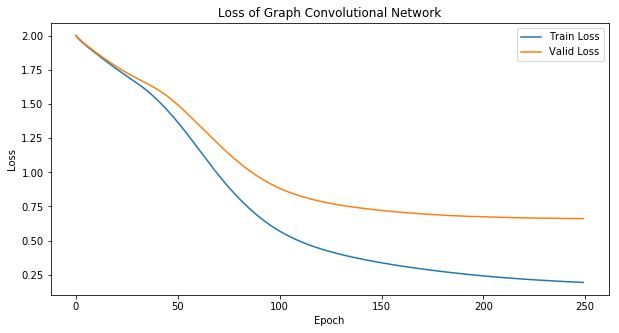

In [17]:
plt.figure(figsize=(10,5))
plt.title("Loss of Graph Convolutional Network")
plt.plot(train_loss_history, label="Train Loss")
plt.plot(valid_loss_history, label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/final_loss_gcn.png')
plt.show()

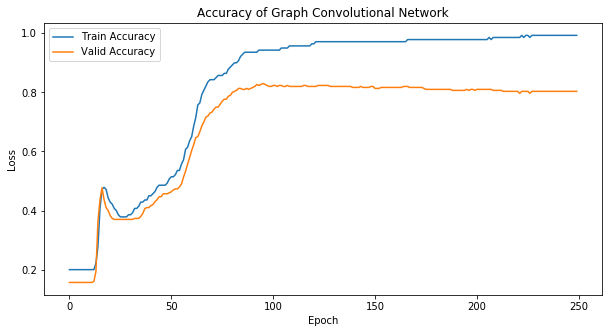

In [18]:
plt.figure(figsize=(10,5))
plt.title("Accuracy of Graph Convolutional Network")
plt.plot(train_accuracy_history, label="Train Accuracy")
plt.plot(valid_accuracy_history, label="Valid Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/final_accuracy_gcn.png')
plt.show()

## Test The Network

In [19]:
gcn.eval()
results = gcn(features, adjacency)
test_loss = F.nll_loss(results[idx_test], labels[idx_test])
test_accuracy = calculate_accuracy(results[idx_test], labels[idx_test])
print("Test Results |", "Test Loss= {:.2f}%, ".format(test_loss.item() * 100), 
                        "Test Accuracy= {:.2f}%".format(test_accuracy.item() * 100))

Test Results | Test Loss= 64.00%,  Test Accuracy= 82.60%


---